<a href="https://colab.research.google.com/github/m-wallner/drug-activity-sklearn/blob/main/drug-activity-sklearn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drug Activity

## Project overview

The aim of this project was to predict the biological activity or toxicity of a drug or a molecule purely based on its chemical structure. A dataset of molecules in SMILES format was given (provided by the JKU Institute of Machine Learning, not available in this repository), together with activities of these molecules related to 11 different applications, and the goal was to train a machine learning model to predict the activities of new molecules based on the selected model.

First, the molecules in SMILES format are transferred into sparse Morgan fingerprints of length 2048, then various classic machine learning models (Support Vector Regression, AdaBoost and Random Forest) contained in the sklearn library are trained and validated on the validation set. SVR showed the best results in terms of a mean ROC AUC score of 71.3% on the 11 different tasks contained in the test set.

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score

from imblearn.over_sampling import ADASYN

## Data inspection

### Training data

In [2]:
data_train = pd.read_csv('data_train.csv', index_col=0)
data_train

,smiles,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,CC1=NN(c2ccc(C)c(C)c2)C(=O)C1N=Nc1cccc(-c2cccc...,0,0,0,0,0,0,0,0,0,0,0
1,CCOP(=S)(OCC)Oc1ccc(S(C)=O)cc1,0,0,0,0,0,0,0,0,-1,-1,0
2,CN(c1ccccc1CN=c1[nH]c(Nc2ccc3c(c2)CC(=O)N3)ncc...,0,0,0,0,0,0,0,-1,0,0,0
3,CC#CC1(O)CCC2C3CCC4=CC(=O)CCC4=C3C(c3ccc(N(C)C...,0,0,0,0,0,0,0,0,1,1,1
4,O=C(O)C1(C(O)=Nc2ccc(Cl)cc2Cl)CC1,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11995,C[C@]12CC(=O)C3C(CCC4=CC(=O)CC[C@@]43C)C1CC[C@...,0,0,0,0,0,0,0,-1,0,0,0
11996,CC(=Cc1ccc(C(=O)O)cc1)c1ccc2c(c1)C(C)(C)CCC2(C)C,0,0,0,0,0,0,0,0,0,0,0
11997,OC[C@H]1NC[C@@H](O)[C@@H](O)[C@@H]1O,0,0,0,0,0,0,0,-1,0,0,0
11998,CN(C)CCCN1c2ccccc2C(C)(C)c2ccccc21,0,0,1,0,0,0,0,0,1,-1,0


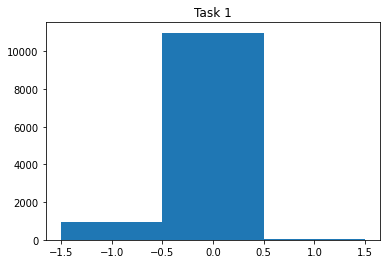

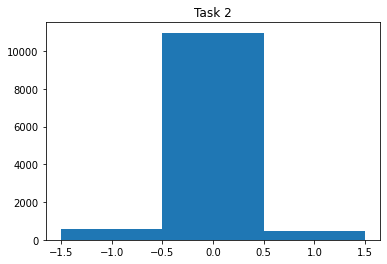

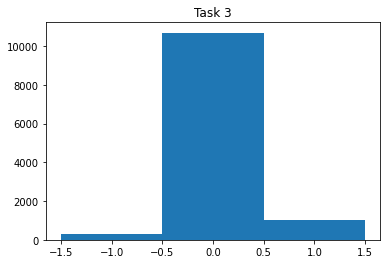

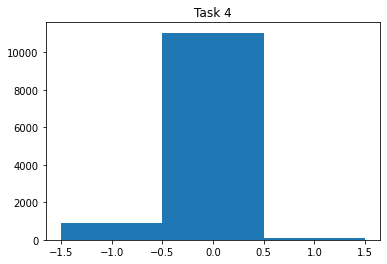

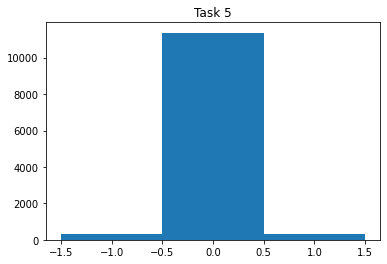

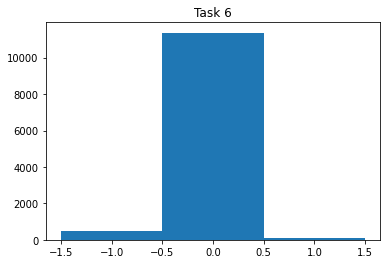

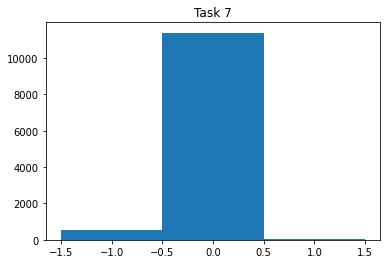

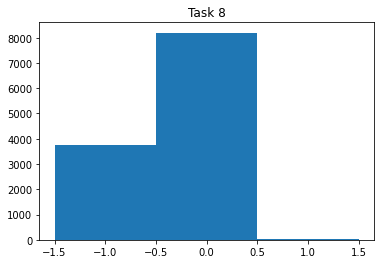

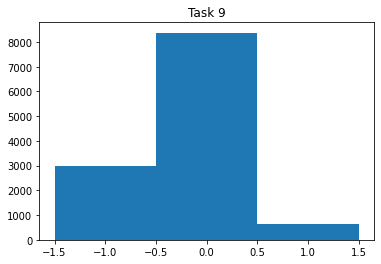

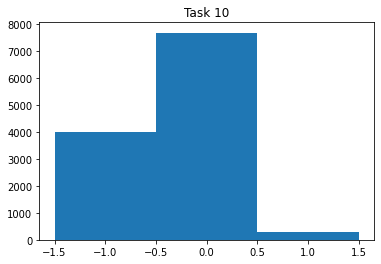

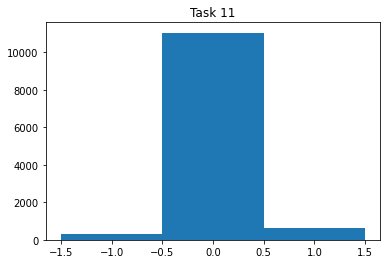

In [3]:
# Visualisation of data using histograms
for i in range(1, 12):
    plt.hist(data_train['task' + str(i)], [-1.5, -0.5, 0.5, 1.5])
    plt.title('Task ' + str(i))
    plt.show()

### Test data

In [4]:
data_test = pd.read_csv('smiles_test.csv')
data_test

,Unnamed: 0,smiles
0,0,COc1cccc(C=O)c1
1,1,N#CC(O)c1ccccc1
2,2,Cl.Cl.OCCN1CCN(CCC=C2c3ccccc3Sc3ccc(Cl)cc32)CC1
3,3,CCN1CCN(c2ccc(C(C)(C)N=C(O)c3cc4[nH]c5ccccc5c(...
4,4,CCCc1ccc(O)c(OC)c1
...,...,...
5891,5891,Cc1cc(C)c(/C=C2\C(O)=Nc3ccccc32)[nH]1
5892,5892,CCCCCCOCCO
5893,5893,CC(c1ccc(O)cc1)c1ccc(O)cc1
5894,5894,CCC(C)(c1ccc(O)cc1)c1ccc(O)cc1


## Preprocessing

### Smiles to Morgan fingerprints

In [5]:
# Turn molecules in smiles format into Morgan fingerprints
def smiles_to_morgan(data: np.array, fp_length=1024):
    desc_mtx = np.zeros((len(data), fp_length)) * np.nan

    # Get Morgan fingerprints
    for i, smiles in enumerate(data):
        mol = Chem.MolFromSmiles(smiles)
        desc_mtx[i] = AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=fp_length)
        
    return desc_mtx

In [6]:
# Define train and test sets by getting Morgan fingerprints
X = smiles_to_morgan(np.array(data_train['smiles']), fp_length=2048)
X_test = smiles_to_morgan(np.array(data_test['smiles']), fp_length=2048)

print(X.shape, X_test.shape)

RDKit WARNING: [14:17:04] WARNING: not removing hydrogen atom without neighbors
[14:17:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:17:04] WARNING: not removing hydrogen atom without neighbors
[14:17:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:17:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:17:04] WARNING: not removing hydrogen atom without neighbors
[14:17:04] WARNING: not removing hydrogen atom without neighbors
[14:17:04] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:17:15] WARNING: not removing hydrogen atom without neighbors
[14:17:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:17:15] WARNING: not removing hydrogen atom without neighbors
[14:17:15] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [14:17:17] WARNING: not removing hydrogen atom without neighbors
[14:17:17] WARNING: not removing hydrogen atom wit

(12000, 2048) (5896, 2048)


In [7]:
# Create task-only dataframe
tasks = data_train.drop('smiles', axis=1)
tasks

,task1,task2,task3,task4,task5,task6,task7,task8,task9,task10,task11
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,-1,-1,0
2,0,0,0,0,0,0,0,-1,0,0,0
3,0,0,0,0,0,0,0,0,1,1,1
4,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
11995,0,0,0,0,0,0,0,-1,0,0,0
11996,0,0,0,0,0,0,0,0,0,0,0
11997,0,0,0,0,0,0,0,-1,0,0,0
11998,0,0,1,0,0,0,0,0,1,-1,0


In [8]:
# Get labels from tasks dataframe
y = [np.array(tasks[col]) for col in tasks]
y

[array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 1, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, ..., 0, 0, 0]),
 array([ 0,  0, -1, ..., -1,  0,  0]),
 array([ 0, -1,  0, ...,  0,  1,  0]),
 array([ 0, -1,  0, ...,  0, -1,  0]),
 array([0, 0, 0, ..., 0, 0, 0])]

In [9]:
# Create filters to mask out tasks with 0-labels
task_filters = [np.where(label!=0) for label in y]
task_filters[0]

(array([   12,    18,    23, ..., 11962, 11980, 11991]),)

## Support Vector Regression

In [12]:
seed = 42
roc_auc_scores = []
predictions_testset = {}
param_grid = {
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 1, 10]
}

for i, mask in enumerate(task_filters):
    
    # Train / Validation split
    X_train, X_valid, y_train, y_valid = train_test_split(X[mask], y[i][mask], test_size=0.1, random_state=seed)
    
    # Resample training data
    X_train, y_train = ADASYN().fit_resample(X_train, y_train)
    
    # Define and train model
    clf = GridSearchCV(SVR(kernel='rbf'), param_grid, n_jobs=-1)
    clf.fit(X_train, y_train)
    
    # Bagging regressor based on model
    clf_bagg = BaggingRegressor(base_estimator=clf, n_estimators=10, n_jobs=-1, random_state=seed)
    clf_bagg.fit(X_train, y_train)
    
    # Validation
    y_hat_proba = clf_bagg.predict(X_valid)
    roc_auc_scores.append(roc_auc_score(y_valid, y_hat_proba))
    print('ROC AUC score task ' + str(i + 1 )+ ':', roc_auc_scores[i])
    
    # Test
    predictions_testset['task' + str(i+1)] = clf.predict(X_test)

# Print mean score
print('Mean ROC AUC score:', np.mean(roc_auc_scores))
          
# Dump CSV file
pd.DataFrame(predictions_testset).to_csv('submission_svr.csv')

ROC AUC score task 1: 0.5208333333333334
ROC AUC score task 2: 0.9321128909229596
ROC AUC score task 3: 0.8954248366013072
ROC AUC score task 4: 0.725925925925926
ROC AUC score task 5: 0.5341796875
ROC AUC score task 6: 0.614065180102916
ROC AUC score task 7: 0.6091954022988506
ROC AUC score task 8: 0.6218487394957982
ROC AUC score task 9: 0.830269892973476
ROC AUC score task 10: 0.8520543783701678
ROC AUC score task 11: 0.5450928381962865
Mean ROC AUC score: 0.698273009611002


## AdaBoost

In [ ]:
seed = 42
roc_auc_scores = []
predictions_testset = {}

for i, mask in enumerate(task_filters):
    
    # Train / Validation split
    X_train, X_valid, y_train, y_valid = train_test_split(X[mask], y[i][mask], test_size=0.1, random_state=seed)
    
    # Resa mple training data
    X_train, y_train = ADASYN().fit_resample(X_train, y_train)
    
    # Define and train model
    clf = AdaBoostClassifier(n_estimators=100)
    clf.fit(X_train, y_train)
    
    # Bagging regressor based on model
    clf_bagg = BaggingRegressor(base_estimator=clf, n_estimators=100, random_state=seed)
    clf_bagg.fit(X_train, y_train)
    
    # Validation
    y_hat_proba = clf_bagg.predict(X_valid)
    roc_auc_scores.append(roc_auc_score(y_valid, y_hat_proba))
    print('ROC AUC score task ' + str(i + 1 )+ ':', roc_auc_scores[i])
    
    # Test
    predictions_testset['task' + str(i+1)] = clf.predict(X_test)

# Print mean score
print('Mean ROC AUC score:', np.mean(roc_auc_scores))
          
# Dump CSV file
pd.DataFrame(predictions_testset).to_csv('submission_adaboost.csv')

ROC AUC score task 1: 0.5125000000000001
ROC AUC score task 2: 0.9101830663615561
ROC AUC score task 3: 0.8743464052287582
ROC AUC score task 4: 0.624074074074074
ROC AUC score task 5: 0.54345703125
ROC AUC score task 6: 0.6149228130360206
ROC AUC score task 7: 0.6408045977011494
ROC AUC score task 8: 0.4652406417112299


## Random Forest

In [ ]:
seed = 42
roc_auc_scores = []
predictions_testset = {}

for i, mask in enumerate(task_filters):
    
    # Train / Validation split
    X_train, X_valid, y_train, y_valid = train_test_split(X[mask], y[i][mask], test_size=0.1, random_state=seed)
    
    # Resample training data
    X_train, y_train = ADASYN().fit_resample(X_train, y_train)
    
    # Define and train model
    clf = RandomForestClassifier(n_estimators=20, random_state=seed)
    clf.fit(X_train, y_train)
    
    # Bagging regressor based on model
    clf_bagg = BaggingRegressor(base_estimator=clf, n_estimators=100, n_jobs=-1, random_state=seed)
    clf_bagg.fit(X_train, y_train)
    
    # Validation
    y_hat_proba = clf_bagg.predict(X_valid)
    roc_auc_scores.append(roc_auc_score(y_valid, y_hat_proba))
    print('ROC AUC score task ' + str(i + 1 )+ ':', roc_auc_scores[i])
    
    # Test
    predictions_testset['task' + str(i+1)] = clf.predict(X_test)

# Print mean score
print('Mean ROC AUC score:', np.mean(roc_auc_scores))
          
# Dump CSV file
pd.DataFrame(predictions_testset).to_csv('submission_rf_bagg.csv')

ROC AUC score task 1: 0.4895833333333333
ROC AUC score task 2: 0.9239130434782608
ROC AUC score task 3: 0.8810457516339869
ROC AUC score task 4: 0.6314814814814815
ROC AUC score task 5: 0.5615234375
ROC AUC score task 6: 0.5591766723842195
ROC AUC score task 7: 0.6436781609195402
ROC AUC score task 8: 0.5
ROC AUC score task 9: 0.8016810144253141
ROC AUC score task 10: 0.7243867243867244
ROC AUC score task 11: 0.5652077807250221
Mean ROC AUC score: 0.6619706727516257
